In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Scikit-learn
from sklearn.metrics import r2_score

In [2]:
# distribuição a priori dos  valores de parâmetros da rede neural
# opta-se por utilizar distibuições que consistem em misturas de distribuições normais gaussianas
class GaussianMixturePrior():
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)

    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi*prob1 + (1 - self.pi)*prob2)).sum()

In [3]:
class GaussianPrior():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.gaussian = torch.distributions.Normal(mu, sigma)
        
    def log_prob(self, input):
        return self.gaussian.log_prob(input).sum()

In [4]:
# distribuição variacional a posteriori dos valores de parâmetros da rede neural
# opta-se por distribuições normais gaussianas: theta = (mu, rho)
class VariationalPosterior():
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
        
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    def sample(self):
        epsilon = self.normal.sample(self.rho.size())
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        return (- math.log(math.sqrt(2*math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu)**2) / (2 * self.sigma**2)).sum()

In [5]:
# camada de uma rede neural bayesiana
class BayesianLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # distribuição variacional a posteriori dos parâmetros
        # parâmetros pesos
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.empty(out_features, in_features).uniform_(-5,-4))
        self.weight = VariationalPosterior(self.weight_mu, self.weight_rho)

        # parâmetros bias
        self.bias_mu = nn.Parameter(torch.empty(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.empty(out_features).uniform_(-5,-4))
        self.bias = VariationalPosterior(self.bias_mu, self.bias_rho)

        # distribuição a priori dos parâmetros
        # parâmetros peso
        self.weight_prior = GaussianMixturePrior(PI, SIGMA_1, SIGMA_2)
        # self.weight_prior = GaussianPrior(MU, SIGMA)
        # parâmetros bias
        self.bias_prior = GaussianMixturePrior(PI, SIGMA_1, SIGMA_2)
        # self.bias_prior = GaussianPrior(MU, SIGMA)
        
        # log verossimilhança dos valores dos parâmetros para as distibuições a priori
        self.log_prior = 0
        # log verossimilhança dos valores dos parâmetros para as distibuições a posteriori
        self.log_variational_posterior = 0

    def forward(self, inputs, sample=False):
        # amostragem de valores de parâmetros peso e bias
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        # média das distribuições dos parâmetros
        else:
            weight = self.weight.mu
            bias = self.bias.mu
            
        # log verossimilhança dos valores dos parâmetros para as distibuições a priori e a posteriori para os valores amostrados
        if self.training:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(inputs, weight, bias)

In [6]:
# estruturação da rede neural bayesiana
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLayer(1, 100)
        self.l2 = BayesianLayer(100, 1)

    def forward(self, x, sample=False):
        x = x.view(-1, 1)
        x = F.relu(self.l1(x, sample))
        x = self.l2(x, sample)
        return x
    
    # log verossimilhança total dos valores amostrados de parâmetros para as distibuições a priori
    def log_prior(self):
        return self.l1.log_prior + self.l2.log_prior
    
    # log verossimilhança total dos valores amostrados de parâmetros para as distibuições a posteriori
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior + self.l2.log_variational_posterior
    
    # log verossimilhança total dos dados e os parâmetros amostrados
    '''def log_likelihood_prob(self, targets, means):
        return (-0.5*((targets - means)**2)).sum()'''
    # negative log likelihood
    def neg_log_likelihood(self, output, target, sigma, no_dim):
        exponent = -0.5*(target - output)**2/sigma**2
        log_coeff = -no_dim*torch.log(sigma)  
        return (log_coeff + exponent).sum()
        
    # função custo para otimização da rede neural
    def sample_elbo(self, inputs, targets, samples, batch_size, num_batches):
        
        # tensores para armazenar as amostras de resposta da rede neural
        output_samples = torch.zeros(samples, batch_size)
        
        # tensores para armazenar os valores de log verossimilhança a priori e a posteriori
        log_prior_samples = torch.zeros(samples)
        log_variational_posterior_samples = torch.zeros(samples)
        log_likelihood_samples = torch.zeros(samples)
        
        # amostragem de repostas da rede neural
        noise = torch.Tensor([[3]])
        for i in range(samples):
            output_samples[i] = self.forward(inputs, sample=True).view(1,-1)
            log_prior_samples[i] = self.log_prior()
            log_variational_posterior_samples[i] = self.log_variational_posterior()
            # log_likelihood_samples[i] = self.log_likelihood_prob(targets, output_samples[i])
            log_likelihood_samples[i] = self.neg_log_likelihood(output_samples[i], targets, noise, 1)
            
        
        # média das amostras de valores de log verossimilhança a priori e a posteriori
        log_prior = log_prior_samples.mean()
        log_variational_posterior = log_variational_posterior_samples.mean()
        # média das amostras de log verossimilhança da rede neural
        log_likelihood = log_likelihood_samples.mean()
        
        # kl divergence entre as distribuições variacionais a posteriori e as distribuições a priori
        kl_divergence = log_variational_posterior - log_prior
        
        # função custo 
        loss = (kl_divergence)/num_batches - log_likelihood
        
        return loss, kl_divergence, -log_likelihood

In [7]:
# função para geração dos dados
np.random.seed(2)
def define_dataset(rebuild_data = False, size = 50):
    if rebuild_data == True:
        X = np.random.uniform(-4, 4, size=size).reshape(-1, 1)
        noise = np.random.normal(0, 3, size=size).reshape(-1, 1)
        y = X ** 3 + noise
        data = np.hstack((X,y))
        np.save('dataset.npy', data)    
    dataset = np.load('dataset.npy')
    return dataset

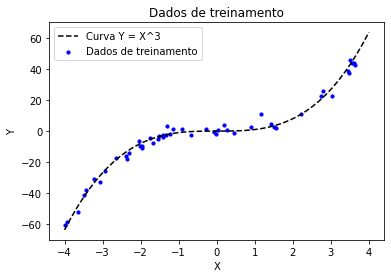

In [8]:
# dados de treinamento
dataset = define_dataset(rebuild_data = False, size = 50)
X_train = dataset[:,0]
y_train = dataset[:,1]

# curva real
X_true = np.linspace(-4, 4, 50).reshape(-1, 1)
y_true = X_true ** 3

# conversão para tensores
X_train_tensor = torch.as_tensor(X_train, dtype = torch.float32).view(-1,1)
y_train_tensor = torch.as_tensor(y_train, dtype = torch.float32).view(-1,1)

# plot dos dados 
plt.scatter(X_train, y_train, marker='o', label='Dados de treinamento', c='b', s=10)
plt.plot(X_true, y_true, 'k--', label='Curva Y = X^3')
plt.title('Dados de treinamento')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('train_data.png')
plt.show()

In [9]:
# conversão para tensor (tem que ser float32)
train_data = torch.as_tensor(dataset, dtype = torch.float32)
BATCH_SIZE = 50
# data loader para a rede neural
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)

In [10]:
# iniciar rede neural
PI = 0.5
SIGMA_1 = torch.FloatTensor([1.5])
SIGMA_2 = torch.FloatTensor([0.1])
MU = torch.FloatTensor([0])
SIGMA = torch.FloatTensor([1])
SAMPLES = 10
NUM_BATCHES = len(train_data_loader.dataset) / BATCH_SIZE
EPOCHS = 200
assert (len(train_data_loader.dataset) % BATCH_SIZE) == 0
net = BayesianNetwork()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.23it/s]


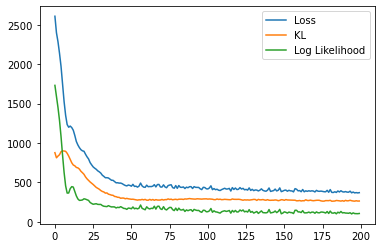

In [11]:
def train(net, optimizer, epoch):
    net.train()
    for batch_id, data in enumerate(train_data_loader):
        inputs = data[:,0]
        targets = data[:,1]
        net.zero_grad()
        loss, kl, lkh = net.sample_elbo(inputs, targets, samples = SAMPLES, batch_size = BATCH_SIZE, num_batches = NUM_BATCHES)
        loss.backward()
        optimizer.step()
    return loss, kl, lkh

optimizer = optim.Adam(net.parameters(), lr=0.08)
loss_log = []
kl_log = []
lkh_log = []
for epoch in tqdm(range(EPOCHS)):
    loss, kl, lkh = train(net, optimizer, epoch)
    loss_log.append(loss.item())
    kl_log.append(kl.item())
    lkh_log.append(lkh.item())
plt.plot(range(EPOCHS), loss_log, label = 'Loss')
plt.plot(range(EPOCHS), kl_log, label = 'KL')
plt.plot(range(EPOCHS), lkh_log, label = 'Log Likelihood')
plt.legend()
plt.show()

In [12]:
# Dados de teste
X_test = np.linspace(-5,5)
y_test = X_test ** 3
X_test_tensor = torch.as_tensor(X_test, dtype = torch.float32).view(-1,1)
y_test_tensor = torch.as_tensor(y_test, dtype = torch.float32).view(-1,1)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3469.46it/s]


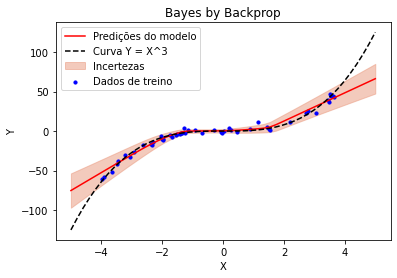

In [13]:
TEST_NUM_POINTS = len(X_test)
T = 1000

net.eval()
y_pred_list = []
uncertainty_list = []
with torch.no_grad():
    y_pred_samples = torch.zeros(T, TEST_NUM_POINTS)
    for i in tqdm(range(T)):
        y_pred_samples[i] = net(X_test_tensor, sample=True).view(1,-1)
    y_pred_mean = y_pred_samples.mean(0)
    y_pred_var = y_pred_samples.var(0)
   
    
y_pred_mean = np.asarray(y_pred_mean.tolist())
y_pred_var = np.asarray(y_pred_var.tolist())


plt.plot(X_test, y_pred_mean, 'r-', label='Predições do modelo')
plt.fill_between(X_test, 
                 y_pred_mean + 3*(y_pred_var**0.5), 
                 y_pred_mean - 3*(y_pred_var**0.5), 
                 alpha=0.5, color ='darksalmon', label='Incertezas')
plt.plot(X_test, y_test, 'k--', label='Curva Y = X^3')
plt.scatter(X_train, y_train, marker='o', c='b', label='Dados de treino',  s=10)
plt.title('Bayes by Backprop')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('bayesbybackprop.png')
plt.show()

Coefficient of Determination $R^{2}$

In [14]:
r2 = r2_score(y_test, y_pred_mean)
r2

0.8800552762780927